### LIBS & CONNECTOR

In [101]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sqlalchemy as sa
import mysql.connector
import getpass
import warnings
warnings.filterwarnings("ignore")

In [102]:
# from gensim.models import Word2Vec
# from gensim.test.utils import common_texts
# from nltk import word_tokenize
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score
# from hdbscan import HDBSCAN

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict, cross_val_score

In [104]:
from sklearn.svm import LinearSVC

In [105]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [106]:
from setup import setup
pool = setup()

Current time:  2023-06-07 15:35:58


In [107]:
from models.doc2vec import Doc2VecModel

### DATA

In [108]:
query = sa.text(
    "SELECT * FROM books;"
)
books_df = pd.read_sql_query(query, con=pool.connect())

In [109]:
query = sa.text(
    "SELECT user_id, goodreads_book_id, (rating * 0.2) as rating from new_ratings_;"
)
user_ratings = pd.read_sql_query(query, con=pool.connect())

### MODEL

In [110]:
book_id = 'goodreads_book_id'
description = 'description'
model = Doc2VecModel(books_df, book_id, description)
model.fit()
model.get_recommendations('3')

,goodreads_book_id,isbn,isbn13,original_publication_year,original_title,title,language_code,average_rating,ratings_count,description
5967,6266907,316070629,9780316070620.0,2009.0,Alex Cross's Trial,"Alex Cross's Trial (Alex Cross, #15)",eng,3.92,17655,"Separated by timeFrom his grandmother, Alex Cr..."
7680,20883847,316219126,9780316219130.0,2015.0,The Autumn Republic,"The Autumn Republic (Powder Mage, #3)",eng,4.35,10910,The capital has fallen...Field Marshal Tamas r...
8270,40271,312850530,9780312850530.0,1995.0,Alvin Journeyman (Tales of Alvin Maker #4),"Alvin Journeyman (Tales of Alvin Maker, #4)",eng,3.72,12663,"Alvin Miller, a gifted seventh son of a sevent..."
7478,179264,60825316,9780060825320.0,2006.0,The Madonnas of Leningrad,The Madonnas of Leningrad,eng,3.77,12620,"Bit by bit, the ravages of age are eroding Mar..."


In [111]:
indices, docvecs = model.get_docvecs()

In [112]:
user_1_books = user_ratings.goodreads_book_id.loc[user_ratings.user_id == '1'].tolist()
user_1_vecs = [docvecs[indices[id]] for id in user_1_books]
user_1_profile = pd.DataFrame(user_1_vecs, columns=range(0,50))
user_1_profile['rating'] = user_ratings.rating.loc[user_ratings.user_id == '1']

In [113]:
random_state = 123
x = user_1_profile.drop(columns=['rating'])
y = user_1_profile.rating.astype('str')

In [114]:
clf = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, class_weight='balanced')

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=123)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.17835497835497835

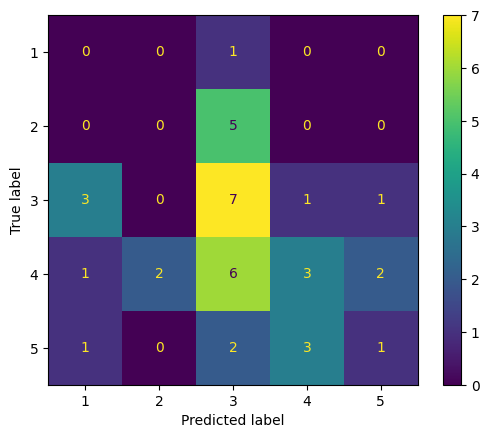

In [116]:
matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['1','2','3','4','5'])
cm_display.plot()
plt.show()